In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Easy

In [2]:
data = pd.read_pickle('../data/train.pickle')
data.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

Поскольку каждая картинка - это трёхмерный массив 32x32x3, выпрямим каждую картинку в массив длины $32\cdot32\cdot3=3072$

In [3]:
features = data['features'].reshape(data['features'].shape[0], data['features'].shape[1] * data['features'].shape[2] * data['features'].shape[3])
x_train, x_test, y_train, y_test = train_test_split(features, data['labels'])
x_train.shape

(26099, 3072)

In [4]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=2000)

Поскольку классы в датасете несбланасированны, будем использовать F1_score

In [5]:
y_pred = model.predict(x_test)
print(f"f1_score = is {f1_score(y_pred, y_test, average='weighted')}")

f1_score = is 0.9520405940799449


### Построим confusion matrix, чтобы понять, какие знаки путает модель больше всего
Подгрузим подписи для большей наглядности

In [6]:
labels_data = pd.read_csv('../data/label_names.csv')
labels = list(labels_data['SignName'])

Text(0.5, 1.0, 'Confusion Matrix')

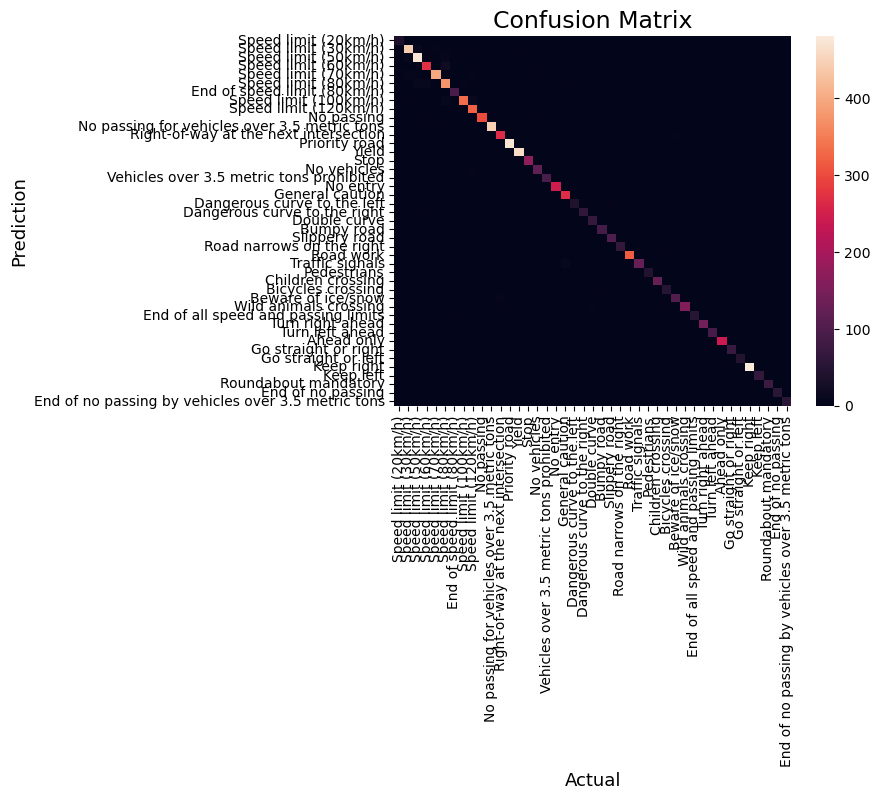

In [7]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, 
            fmt='g', 
            xticklabels=labels,
            yticklabels=labels)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

Читать такой график сложно, поэтому найдём наименьшее значение на диагонали матрицы алгоритмически

In [8]:
most_confused = ""
most_confused_freq = 100000
for i in range(len(cm)):
    if cm[i][i] < most_confused_freq:
        most_confused_freq = cm[i][i]
        most_confused = labels[i]

print(f"The most confused sign is {most_confused}")

The most confused sign is Speed limit (20km/h)


# Medium
Обучим остальные модели и сравним на них метрику

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [10]:
research_results = {"LogisticRegression": f1_score(y_pred, y_test, average='weighted')}

### Обучение KNN
Проверим все $K \in [1; 7]$ (потому что не жалко)

In [11]:
for K in range(1, 8, 1):
    model = KNeighborsClassifier(K)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    research_results["KNN" + str(K)] = f1_score(y_pred, y_test, average='weighted')
    print("KNN" + str(K), f1_score(y_pred, y_test, average='weighted'))

KNN1 0.9315614823860237
KNN2 0.9029105601328414
KNN3 0.8996279931894137
KNN4 0.888598134021503
KNN5 0.873756604391574
KNN6 0.8637953097546028
KNN7 0.8546315548553309


### Обучение НБК

In [12]:
model = MultinomialNB()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
research_results["MultinomialNB"] = f1_score(y_pred, y_test, average='weighted')
print(f"MultinomialNB: {f1_score(y_pred, y_test, average='weighted')}")

MultinomialNB: 0.30159310747583373


### Обучение SVM (три ядра)

In [13]:
model = SVC(kernel='linear')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
research_results["SVClinear"] = f1_score(y_pred, y_test, average='weighted')
print("SVClinear", f1_score(y_pred, y_test, average='weighted'))

SVClinear 0.9565533954454984


In [14]:
model = SVC(kernel='poly')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
research_results["SVCpoly"] = f1_score(y_pred, y_test, average='weighted')
print("SVCpoly", f1_score(y_pred, y_test, average='weighted'))

SVCpoly 0.6698365628783507


In [15]:
model = SVC(kernel='rbf')
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
research_results["SVCrbf"] = f1_score(y_pred, y_test, average='weighted')
print("SVCrbf", f1_score(y_pred, y_test, average='weighted'))

SVCrbf 0.8744980693620824


Посмотрим метрики наших моделей

In [16]:
research_results

{'LogisticRegression': 0.9520405940799449,
 'KNN1': 0.9315614823860237,
 'KNN2': 0.9029105601328414,
 'KNN3': 0.8996279931894137,
 'KNN4': 0.888598134021503,
 'KNN5': 0.873756604391574,
 'KNN6': 0.8637953097546028,
 'KNN7': 0.8546315548553309,
 'MultinomialNB': 0.30159310747583373,
 'SVClinear': 0.9565533954454984,
 'SVCpoly': 0.6698365628783507,
 'SVCrbf': 0.8744980693620824}

Хуже всех, как и ожидалось, сработал наивный байесовский классификатор, поскольку он работает в предположении, что все фичи независимы, что определённо не так в случае с картинками. Лучше всех сработали логистическая регрессия и SVM с линейным ядром.